In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('solar2019.csv')
df.head(100)
idx_df = df.set_index(['时间'])
idx_df.describe().T  #用于计算数值列的描述性统计信息，如计数、均值、标准差、最小值、最大值等
idx_df.head(10)
idx_df.isnull().sum()#DataFrame 中每列的缺失值数量。通过这个操作，您可以了解每列中缺失值的分布情况，并进行进一步的数据清洗或处理。
idx_df.corr()['实际发电功率(mw)'].sort_values(ascending=False)
print(idx_df.shape)
idx_df.info()
df1 = idx_df['实际发电功率(mw)']
df2 = idx_df.drop(['实际发电功率(mw)'],axis=1)

print(df1.shape)
from vmdpy import VMD
tau = 0.  # noise-tolerance (no strict fidelity enforcement)
DC = 0  # no DC part imposed
init = 1  # initialize omegas uniformly
tol = 1e-7
K=10
alpha=102
u, u_hat, omega = VMD(df1, alpha, tau, K, DC, init, tol)
print(u)
u=u.T
print(u.shape)
print(u)
x = u[:,0]
print(x.shape)
# 将x = u[:,0]作为一个新的列添加到df2
df['imf1']=u[:,0]
df['imf2']=u[:,1]
df['imf3']=u[:,2]
df['imf4']=u[:,3]
df['imf5']=u[:,4]
df['imf6']=u[:,5]
df['imf7']=u[:,6]
df['imf8']=u[:,7]
df['imf9']=u[:,8]
df['imf10']=u[:,9]

idx_df.corr()['实际发电功率(mw)'].sort_values(ascending=False) #在这里环境的阈值和vmd的分量的阈值都定义为0.1
df2.shape
print(df2)


import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Bidirectional,GRU,Input, Conv1D,Multiply,Flatten,MaxPooling1D,concatenate,GlobalAveragePooling1D,Reshape
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout,Permute,Lambda,RepeatVector
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

#通道注意力机制
def SE_Block(input_tensor,ratio = 2):
    input_shape = K.int_shape(input_tensor)
    squeeze = tf.keras.layers.GlobalAveragePooling1D()(input_tensor)
    excitation = tf.keras.layers.Dense(units = input_shape[-1]//ratio, kernel_initializer='he_normal',activation='relu')(squeeze)
    excitation = tf.keras.layers.Dense(units = input_shape[-1],activation='sigmoid')(excitation)
    #excitation = tf.reshape(excitation, [-1, 1, input_shape[-1]])
    scale = tf.keras.layers.Multiply()([input_tensor, excitation])
    return scale


predictions_list = []  # 创建一个空列表用于存储预测结果

for i in range(10):
    x = u[:, i]
    df2['x'] = u[:, i]
    #   print(df2)
    y_train_set = df2.iloc[:24528, 7:8].values  # 目标点
    y_val_set = df2.iloc[24528:31536, 7:8].values  # 目标点
    # y_test_set = df2.iloc[31536:35040,7:8].values

    x_train_set = df2.iloc[:24528, :8].values  # 其它特征
    x_val_set = df2.iloc[24528:31536, :8].values
    x_test_set = df2.iloc[31969:32064, :8].values

    x_sc = MinMaxScaler()
    x_train2 = x_sc.fit_transform(x_train_set)
    x_val2 = x_sc.transform(x_val_set)
    x_test2 = x_sc.transform(x_test_set)
    y_sc = MinMaxScaler()
    y_train2 = y_sc.fit_transform(y_train_set)
    y_val2 = y_sc.transform(y_val_set)

    x_train = []
    y_train = []

    x_val = []
    y_val = []

    x_test = []

    # 利用for循环，
    for i in range(8, len(x_train2)):
        x_train.append(x_train2[i - 8:i, :])
        y_train.append(y_train2[i, :])

    # 对训练集进行打乱
    np.random.seed(7)
    np.random.shuffle(x_train)
    np.random.seed(7)
    np.random.shuffle(y_train)
    tf.random.set_seed(7)
    # 将训练集由list格式变为array格式
    x_train, y_train = np.array(x_train), np.array(y_train)

    y_train = np.reshape(y_train, (y_train.shape[0],))

    # 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。

    # 利用for循环
    for i in range(8, len(x_val2)):
        x_val.append(x_val2[i - 8:i, :])
        y_val.append(y_val2[i, :])
    # 测试集变array并reshape为符合LSTM输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
    x_val, y_val = np.array(x_val), np.array(y_val)
    y_val = np.reshape(y_val, (y_val.shape[0],))  # 标签为一维数组

    for i in range(8, len(x_test2)):
        x_test.append(x_test2[i - 8:i, :])

    # 测试集变array并reshape为符合LSTM输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
    x_test = np.array(x_test)


    def double_CNN_GRU():
        visible1 = Input(shape=(8, 8))
        #     cnn1 = Conv1D(filters=8, kernel_size=1, activation='relu',padding='same')(visible1)   #output_length = seq_length - kernel_size + 1=24-3+1=22  (22,8)
        #     cnn1 = MaxPooling1D(pool_size=2)(cnn1)  #output_length = ceil(seq_length / pool_size)=22/2=11   (11,8)
        #     cnn2 = Conv1D(filters=16, kernel_size=3, activation='relu')(cnn1)  #11-3+1=9   (9,16)
        #     cnn2 = MaxPooling1D(pool_size=2)(cnn2)   # (9/2,16)=(4,16)
        #     cnn = Flatten()(cnn2)  #4*16=64
        #     cnn2_with_se = SE_Block(visible1, ratio=8)
        #     SENet = Flatten()(cnn2_with_se)

        #     cs = SE_Block(visible1,ratio = 2)
        cnn1 = Conv1D(filters=8, kernel_size=1, activation='relu', padding='same')(visible1)
        #     cnn1 = MaxPooling1D(pool_size=2)(cnn1)
        cs = SE_Block(cnn1, ratio=2)
        cnn2 = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(cs)  # 11-3+1=9   (9,16)
        cnn2 = MaxPooling1D(pool_size=2)(cnn2)  # (9/2,16)=(4,16)
        cnn = Flatten()(cnn2)

        visible2 = Input(shape=(8, 8))
        gru1 = Bidirectional(GRU(units=32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)))(
            visible2)  # (24,32)
        gru2 = Bidirectional(GRU(units=16, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01)))(
            gru1)
        gru = Flatten()(gru2)

        merge = concatenate([cnn, gru])

        #     # 添加自注意力层
        #     self_attention_layer = SelfAttention(d_model=32)  # 假设自注意力层的输出维度为32
        #     attention = self_attention_layer(merge)
        # 用于将输入层的数据压成一维的数据，一般用再卷积层和全连接层之间
        attention_probs = Dense(96, activation='sigmoid', name='attention_vec')(merge)
        attention_mul = Multiply()([merge, attention_probs])
        F = Flatten()(attention_mul)

        dense = Dense(units=64, activation='relu')(F)
        output = Dense(units=1, activation='relu')(dense)
        model = Model(inputs=[visible1, visible2], outputs=output)
        adam = Adam(learning_rate=0.042205)
        return model


    m = double_CNN_GRU()
    m.summary()
    m.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    hist = m.fit([x_train, x_train], y_train, epochs=100, batch_size=126, validation_data=([x_val, x_val], y_val),
                 verbose=1)

    y_pred = m.predict([x_test, x_test])

    # 对预测数据还原---从（0，1）反归一化到原始范围
    y_pred_original = y_sc.inverse_transform(y_pred)

    predictions_list.append(y_pred_original)



(35040, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 2019-01-01 00:00:00 to 2019-12-31 23:45:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   组件温度(℃)     35040 non-null  float64
 1   温度(°)       35040 non-null  float64
 2   气压(hPa)     35040 non-null  float64
 3   湿度(%)       35040 non-null  float64
 4   总辐射(W/m2)   35040 non-null  float64
 5   直射辐射(W/m2)  35040 non-null  float64
 6   散射辐射(W/m2)  35040 non-null  float64
 7   实际发电功率(mw)  35040 non-null  float64
dtypes: float64(8)
memory usage: 2.4+ MB
(35040,)
[[ 5.42359104e+00  5.42289905e+00  5.42167953e+00 ...  1.20757425e+01
   1.20503350e+01  1.20365859e+01]
 [-5.99406023e+00 -6.02959725e+00 -6.09951630e+00 ... -1.98711790e+01
  -2.01320305e+01 -2.02642429e+01]
 [ 2.73723573e-01  3.12040008e-01  3.87817721e-01 ...  9.39563140e+00
   9.78489583e+00  9.97930331e+00]
 ...
 [ 8.79041453e-04  1.29836388e-03  6.39803187e-04 ... -9.48962548e-04
  -2

195/195 [==============================] - 2s 9ms/step - loss: 0.0486 - root_mean_squared_error: 0.0271 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0402
Epoch 3/100
195/195 [==============================] - 2s 9ms/step - loss: 0.0020 - root_mean_squared_error: 0.0226 - val_loss: 8.9534e-04 - val_root_mean_squared_error: 0.0283
Epoch 4/100
195/195 [==============================] - 2s 9ms/step - loss: 3.6812e-04 - root_mean_squared_error: 0.0178 - val_loss: 4.3066e-04 - val_root_mean_squared_error: 0.0206
Epoch 5/100
195/195 [==============================] - 2s 9ms/step - loss: 2.4910e-04 - root_mean_squared_error: 0.0157 - val_loss: 3.8942e-04 - val_root_mean_squared_error: 0.0197
Epoch 6/100
195/195 [==============================] - 2s 9ms/step - loss: 1.9425e-04 - root_mean_squared_error: 0.0139 - val_loss: 5.4154e-04 - val_root_mean_squared_error: 0.0233
Epoch 7/100
195/195 [==============================] - 2s 9ms/step - loss: 1.5453e-04 - root_mean_squared_error: 0.0124

Epoch 47/100
195/195 [==============================] - 2s 12ms/step - loss: 2.2805e-05 - root_mean_squared_error: 0.0048 - val_loss: 9.0817e-05 - val_root_mean_squared_error: 0.0095
Epoch 48/100
195/195 [==============================] - 2s 12ms/step - loss: 2.0695e-05 - root_mean_squared_error: 0.0045 - val_loss: 1.2621e-04 - val_root_mean_squared_error: 0.0112
Epoch 49/100
195/195 [==============================] - 2s 10ms/step - loss: 1.7668e-05 - root_mean_squared_error: 0.0042 - val_loss: 1.3837e-04 - val_root_mean_squared_error: 0.0118
Epoch 50/100
195/195 [==============================] - 2s 10ms/step - loss: 2.6633e-05 - root_mean_squared_error: 0.0051 - val_loss: 9.3263e-05 - val_root_mean_squared_error: 0.0097
Epoch 51/100
195/195 [==============================] - 2s 10ms/step - loss: 1.9960e-05 - root_mean_squared_error: 0.0045 - val_loss: 9.8859e-05 - val_root_mean_squared_error: 0.0099
Epoch 52/100
195/195 [==============================] - 2s 10ms/step - loss: 1.6765e-

Epoch 92/100
195/195 [==============================] - 2s 11ms/step - loss: 1.2370e-05 - root_mean_squared_error: 0.0035 - val_loss: 7.4156e-05 - val_root_mean_squared_error: 0.0086
Epoch 93/100
195/195 [==============================] - 2s 10ms/step - loss: 1.3392e-05 - root_mean_squared_error: 0.0036 - val_loss: 4.9500e-05 - val_root_mean_squared_error: 0.0070
Epoch 94/100
195/195 [==============================] - 2s 12ms/step - loss: 1.2918e-05 - root_mean_squared_error: 0.0036 - val_loss: 7.9760e-05 - val_root_mean_squared_error: 0.0089
Epoch 95/100
195/195 [==============================] - 2s 11ms/step - loss: 1.2376e-05 - root_mean_squared_error: 0.0035 - val_loss: 5.7942e-05 - val_root_mean_squared_error: 0.0076
Epoch 96/100
195/195 [==============================] - 2s 12ms/step - loss: 1.4085e-05 - root_mean_squared_error: 0.0037 - val_loss: 4.5829e-05 - val_root_mean_squared_error: 0.0068
Epoch 97/100
195/195 [==============================] - 2s 11ms/step - loss: 1.1684e-

195/195 [==============================] - 2s 11ms/step - loss: 5.9428e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.0054e-04 - val_root_mean_squared_error: 0.0142
Epoch 9/100
195/195 [==============================] - 2s 11ms/step - loss: 5.1404e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.2975e-04 - val_root_mean_squared_error: 0.0114
Epoch 10/100
195/195 [==============================] - 2s 11ms/step - loss: 4.5375e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.6276e-04 - val_root_mean_squared_error: 0.0162
Epoch 11/100
195/195 [==============================] - 2s 11ms/step - loss: 4.7742e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.5451e-04 - val_root_mean_squared_error: 0.0124
Epoch 12/100
195/195 [==============================] - 2s 12ms/step - loss: 5.6591e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.6066e-04 - val_root_mean_squared_error: 0.0127
Epoch 13/100
195/195 [==============================] - 2s 12ms/step - loss: 4.0980e-05 - root_mean

Epoch 53/100
195/195 [==============================] - 2s 11ms/step - loss: 3.4731e-05 - root_mean_squared_error: 0.0058 - val_loss: 6.2235e-05 - val_root_mean_squared_error: 0.0079
Epoch 54/100
195/195 [==============================] - 2s 10ms/step - loss: 1.2128e-05 - root_mean_squared_error: 0.0035 - val_loss: 4.5266e-05 - val_root_mean_squared_error: 0.0067
Epoch 55/100
195/195 [==============================] - 2s 10ms/step - loss: 1.0643e-05 - root_mean_squared_error: 0.0033 - val_loss: 9.4559e-05 - val_root_mean_squared_error: 0.0097
Epoch 56/100
195/195 [==============================] - 2s 10ms/step - loss: 1.3338e-05 - root_mean_squared_error: 0.0036 - val_loss: 5.1220e-05 - val_root_mean_squared_error: 0.0072
Epoch 57/100
195/195 [==============================] - 2s 10ms/step - loss: 1.3282e-05 - root_mean_squared_error: 0.0036 - val_loss: 4.1138e-05 - val_root_mean_squared_error: 0.0064
Epoch 58/100
195/195 [==============================] - 2s 10ms/step - loss: 1.5465e-

Epoch 98/100
195/195 [==============================] - 2s 10ms/step - loss: 8.3228e-06 - root_mean_squared_error: 0.0029 - val_loss: 2.1096e-05 - val_root_mean_squared_error: 0.0046
Epoch 99/100
195/195 [==============================] - 2s 10ms/step - loss: 1.0356e-05 - root_mean_squared_error: 0.0032 - val_loss: 2.6463e-05 - val_root_mean_squared_error: 0.0051
Epoch 100/100
195/195 [==============================] - 2s 11ms/step - loss: 8.9661e-06 - root_mean_squared_error: 0.0030 - val_loss: 2.9303e-05 - val_root_mean_squared_error: 0.0054
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 8, 8)]       0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (Non

195/195 [==============================] - 2s 10ms/step - loss: 3.0140e-05 - root_mean_squared_error: 0.0055 - val_loss: 3.4368e-05 - val_root_mean_squared_error: 0.0059
Epoch 15/100
195/195 [==============================] - 2s 10ms/step - loss: 3.1492e-05 - root_mean_squared_error: 0.0056 - val_loss: 3.0649e-05 - val_root_mean_squared_error: 0.0055
Epoch 16/100
195/195 [==============================] - 2s 12ms/step - loss: 3.1272e-05 - root_mean_squared_error: 0.0056 - val_loss: 2.8836e-05 - val_root_mean_squared_error: 0.0054
Epoch 17/100
195/195 [==============================] - 2s 11ms/step - loss: 3.2351e-05 - root_mean_squared_error: 0.0057 - val_loss: 2.8668e-05 - val_root_mean_squared_error: 0.0054
Epoch 18/100
195/195 [==============================] - 2s 10ms/step - loss: 2.7678e-05 - root_mean_squared_error: 0.0053 - val_loss: 4.5067e-05 - val_root_mean_squared_error: 0.0067
Epoch 19/100
195/195 [==============================] - 2s 10ms/step - loss: 3.1350e-05 - root_mea

Epoch 59/100
195/195 [==============================] - 2s 10ms/step - loss: 1.1950e-05 - root_mean_squared_error: 0.0035 - val_loss: 1.6317e-05 - val_root_mean_squared_error: 0.0040
Epoch 60/100
195/195 [==============================] - 2s 11ms/step - loss: 1.1014e-05 - root_mean_squared_error: 0.0033 - val_loss: 1.0131e-05 - val_root_mean_squared_error: 0.0032
Epoch 61/100
195/195 [==============================] - 2s 10ms/step - loss: 1.1213e-05 - root_mean_squared_error: 0.0033 - val_loss: 1.2767e-05 - val_root_mean_squared_error: 0.0036
Epoch 62/100
195/195 [==============================] - 2s 10ms/step - loss: 9.8673e-06 - root_mean_squared_error: 0.0031 - val_loss: 8.3959e-06 - val_root_mean_squared_error: 0.0029
Epoch 63/100
195/195 [==============================] - 2s 10ms/step - loss: 9.4459e-06 - root_mean_squared_error: 0.0031 - val_loss: 9.7232e-06 - val_root_mean_squared_error: 0.0031
Epoch 64/100
195/195 [==============================] - 2s 10ms/step - loss: 1.2374e-

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 8, 8)]       0                                            
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 8, 8)         72          input_27[0][0]                   
__________________________________________________________________________________________________
global_average_pooling1d_13 (Gl (None, 8)            0           conv1d_26[0][0]                  
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 4)            36          global_average_pooling1d_13[0][0]
___________________________________________________________________________________________

195/195 [==============================] - 2s 11ms/step - loss: 6.5148e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.1093e-04 - val_root_mean_squared_error: 0.0105
Epoch 22/100
195/195 [==============================] - 2s 9ms/step - loss: 6.6395e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.0195e-04 - val_root_mean_squared_error: 0.0101
Epoch 23/100
195/195 [==============================] - 2s 9ms/step - loss: 5.7229e-05 - root_mean_squared_error: 0.0076 - val_loss: 9.5778e-05 - val_root_mean_squared_error: 0.0098
Epoch 24/100
195/195 [==============================] - 2s 9ms/step - loss: 5.5802e-05 - root_mean_squared_error: 0.0075 - val_loss: 9.8107e-05 - val_root_mean_squared_error: 0.0099
Epoch 25/100
195/195 [==============================] - 2s 10ms/step - loss: 5.7370e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.0709e-04 - val_root_mean_squared_error: 0.0103
Epoch 26/100
195/195 [==============================] - 2s 11ms/step - loss: 5.1655e-05 - root_mean_s

Epoch 66/100
195/195 [==============================] - 2s 10ms/step - loss: 1.8474e-05 - root_mean_squared_error: 0.0043 - val_loss: 8.6177e-05 - val_root_mean_squared_error: 0.0093
Epoch 67/100
195/195 [==============================] - 2s 10ms/step - loss: 1.5980e-05 - root_mean_squared_error: 0.0040 - val_loss: 4.1204e-05 - val_root_mean_squared_error: 0.0064
Epoch 68/100
195/195 [==============================] - 2s 11ms/step - loss: 1.6676e-05 - root_mean_squared_error: 0.0041 - val_loss: 4.5875e-05 - val_root_mean_squared_error: 0.0068
Epoch 69/100
195/195 [==============================] - 2s 9ms/step - loss: 2.0313e-05 - root_mean_squared_error: 0.0045 - val_loss: 5.2669e-05 - val_root_mean_squared_error: 0.0073
Epoch 70/100
195/195 [==============================] - 2s 10ms/step - loss: 1.9582e-05 - root_mean_squared_error: 0.0044 - val_loss: 5.8241e-05 - val_root_mean_squared_error: 0.0076
Epoch 71/100
195/195 [==============================] - 2s 10ms/step - loss: 1.6244e-0

195/195 [==============================] - 7s 16ms/step - loss: 0.8759 - root_mean_squared_error: 0.1175 - val_loss: 0.0877 - val_root_mean_squared_error: 0.0451
Epoch 2/100
195/195 [==============================] - 2s 10ms/step - loss: 0.0476 - root_mean_squared_error: 0.0379 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0251
Epoch 3/100
195/195 [==============================] - 2s 10ms/step - loss: 0.0019 - root_mean_squared_error: 0.0252 - val_loss: 5.0792e-04 - val_root_mean_squared_error: 0.0208
Epoch 4/100
195/195 [==============================] - 2s 11ms/step - loss: 4.7576e-04 - root_mean_squared_error: 0.0209 - val_loss: 3.0259e-04 - val_root_mean_squared_error: 0.0173
Epoch 5/100
195/195 [==============================] - 2s 11ms/step - loss: 3.1061e-04 - root_mean_squared_error: 0.0176 - val_loss: 2.3379e-04 - val_root_mean_squared_error: 0.0153
Epoch 6/100
195/195 [==============================] - 2s 10ms/step - loss: 2.3922e-04 - root_mean_squared_error: 0.0155 -

195/195 [==============================] - 2s 11ms/step - loss: 4.1521e-05 - root_mean_squared_error: 0.0064 - val_loss: 7.5746e-05 - val_root_mean_squared_error: 0.0087
Epoch 47/100
195/195 [==============================] - 2s 10ms/step - loss: 4.1863e-05 - root_mean_squared_error: 0.0065 - val_loss: 6.1567e-05 - val_root_mean_squared_error: 0.0078
Epoch 48/100
195/195 [==============================] - 2s 9ms/step - loss: 4.5674e-05 - root_mean_squared_error: 0.0068 - val_loss: 6.1385e-05 - val_root_mean_squared_error: 0.0078
Epoch 49/100
195/195 [==============================] - 2s 10ms/step - loss: 4.0316e-05 - root_mean_squared_error: 0.0063 - val_loss: 5.2805e-05 - val_root_mean_squared_error: 0.0073
Epoch 50/100
195/195 [==============================] - 2s 9ms/step - loss: 4.2687e-05 - root_mean_squared_error: 0.0065 - val_loss: 5.5791e-05 - val_root_mean_squared_error: 0.0075
Epoch 51/100
195/195 [==============================] - 2s 10ms/step - loss: 4.1841e-05 - root_mean_

Epoch 91/100
195/195 [==============================] - 2s 10ms/step - loss: 3.0779e-05 - root_mean_squared_error: 0.0055 - val_loss: 4.4479e-05 - val_root_mean_squared_error: 0.0067
Epoch 92/100
195/195 [==============================] - 2s 10ms/step - loss: 3.0964e-05 - root_mean_squared_error: 0.0056 - val_loss: 5.2376e-05 - val_root_mean_squared_error: 0.0072
Epoch 93/100
195/195 [==============================] - 2s 10ms/step - loss: 3.0587e-05 - root_mean_squared_error: 0.0055 - val_loss: 4.7340e-05 - val_root_mean_squared_error: 0.0069
Epoch 94/100
195/195 [==============================] - 2s 10ms/step - loss: 2.6891e-05 - root_mean_squared_error: 0.0052 - val_loss: 4.3920e-05 - val_root_mean_squared_error: 0.0066
Epoch 95/100
195/195 [==============================] - 2s 10ms/step - loss: 2.5485e-05 - root_mean_squared_error: 0.0050 - val_loss: 4.5497e-05 - val_root_mean_squared_error: 0.0067
Epoch 96/100
195/195 [==============================] - 2s 10ms/step - loss: 2.8922e-

195/195 [==============================] - 2s 10ms/step - loss: 1.4198e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.0975e-04 - val_root_mean_squared_error: 0.0105
Epoch 8/100
195/195 [==============================] - 2s 11ms/step - loss: 1.0284e-04 - root_mean_squared_error: 0.0101 - val_loss: 7.8650e-05 - val_root_mean_squared_error: 0.0089
Epoch 9/100
195/195 [==============================] - 2s 11ms/step - loss: 8.8023e-05 - root_mean_squared_error: 0.0094 - val_loss: 6.8511e-05 - val_root_mean_squared_error: 0.0083
Epoch 10/100
195/195 [==============================] - 2s 10ms/step - loss: 7.6542e-05 - root_mean_squared_error: 0.0087 - val_loss: 5.7703e-05 - val_root_mean_squared_error: 0.0076
Epoch 11/100
195/195 [==============================] - 2s 10ms/step - loss: 7.2570e-05 - root_mean_squared_error: 0.0085 - val_loss: 5.2237e-05 - val_root_mean_squared_error: 0.0072
Epoch 12/100
195/195 [==============================] - 2s 10ms/step - loss: 7.0998e-05 - root_mean_

Epoch 52/100
195/195 [==============================] - 2s 11ms/step - loss: 4.0406e-05 - root_mean_squared_error: 0.0064 - val_loss: 4.6956e-05 - val_root_mean_squared_error: 0.0069
Epoch 53/100
195/195 [==============================] - 2s 11ms/step - loss: 4.0454e-05 - root_mean_squared_error: 0.0064 - val_loss: 3.1845e-05 - val_root_mean_squared_error: 0.0056
Epoch 54/100
195/195 [==============================] - 2s 11ms/step - loss: 3.6965e-05 - root_mean_squared_error: 0.0061 - val_loss: 3.1146e-05 - val_root_mean_squared_error: 0.0056
Epoch 55/100
195/195 [==============================] - 2s 10ms/step - loss: 3.7334e-05 - root_mean_squared_error: 0.0061 - val_loss: 3.6890e-05 - val_root_mean_squared_error: 0.0061
Epoch 56/100
195/195 [==============================] - 2s 11ms/step - loss: 3.7616e-05 - root_mean_squared_error: 0.0061 - val_loss: 3.3138e-05 - val_root_mean_squared_error: 0.0058
Epoch 57/100
195/195 [==============================] - 2s 10ms/step - loss: 3.8337e-

Epoch 97/100
195/195 [==============================] - 2s 11ms/step - loss: 3.1325e-05 - root_mean_squared_error: 0.0056 - val_loss: 2.8927e-05 - val_root_mean_squared_error: 0.0054
Epoch 98/100
195/195 [==============================] - 2s 11ms/step - loss: 3.0997e-05 - root_mean_squared_error: 0.0056 - val_loss: 2.6651e-05 - val_root_mean_squared_error: 0.0052
Epoch 99/100
195/195 [==============================] - 2s 10ms/step - loss: 3.0030e-05 - root_mean_squared_error: 0.0055 - val_loss: 2.3643e-05 - val_root_mean_squared_error: 0.0048
Epoch 100/100
195/195 [==============================] - 2s 10ms/step - loss: 3.3285e-05 - root_mean_squared_error: 0.0058 - val_loss: 3.1573e-05 - val_root_mean_squared_error: 0.0056
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 8, 8)]     

195/195 [==============================] - 2s 11ms/step - loss: 1.3239e-04 - root_mean_squared_error: 0.0115 - val_loss: 6.9748e-05 - val_root_mean_squared_error: 0.0084
Epoch 14/100
195/195 [==============================] - 2s 12ms/step - loss: 1.1163e-04 - root_mean_squared_error: 0.0106 - val_loss: 6.4261e-05 - val_root_mean_squared_error: 0.0080
Epoch 15/100
195/195 [==============================] - 2s 11ms/step - loss: 1.1752e-04 - root_mean_squared_error: 0.0108 - val_loss: 6.6169e-05 - val_root_mean_squared_error: 0.0081
Epoch 16/100
195/195 [==============================] - 3s 15ms/step - loss: 9.5422e-05 - root_mean_squared_error: 0.0098 - val_loss: 5.2965e-05 - val_root_mean_squared_error: 0.0073
Epoch 17/100
195/195 [==============================] - 3s 16ms/step - loss: 9.3690e-05 - root_mean_squared_error: 0.0097 - val_loss: 5.1450e-05 - val_root_mean_squared_error: 0.0072
Epoch 18/100
195/195 [==============================] - 3s 15ms/step - loss: 9.1849e-05 - root_mea

Epoch 58/100
195/195 [==============================] - 2s 11ms/step - loss: 5.5840e-05 - root_mean_squared_error: 0.0075 - val_loss: 3.7010e-05 - val_root_mean_squared_error: 0.0061
Epoch 59/100
195/195 [==============================] - 2s 11ms/step - loss: 5.0884e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.6382e-05 - val_root_mean_squared_error: 0.0060
Epoch 60/100
195/195 [==============================] - 2s 11ms/step - loss: 4.9883e-05 - root_mean_squared_error: 0.0071 - val_loss: 4.9381e-05 - val_root_mean_squared_error: 0.0070
Epoch 61/100
195/195 [==============================] - 2s 11ms/step - loss: 6.1296e-05 - root_mean_squared_error: 0.0078 - val_loss: 3.7451e-05 - val_root_mean_squared_error: 0.0061
Epoch 62/100
195/195 [==============================] - 2s 11ms/step - loss: 5.1744e-05 - root_mean_squared_error: 0.0072 - val_loss: 4.0951e-05 - val_root_mean_squared_error: 0.0064
Epoch 63/100
195/195 [==============================] - 2s 11ms/step - loss: 5.1622e-

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 8, 8)]       0                                            
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 8, 8)         72          input_35[0][0]                   
__________________________________________________________________________________________________
global_average_pooling1d_17 (Gl (None, 8)            0           conv1d_34[0][0]                  
__________________________________________________________________________________________________
dense_68 (Dense)                (None, 4)            36          global_average_pooling1d_17[0][0]
___________________________________________________________________________________________

195/195 [==============================] - 2s 10ms/step - loss: 5.4046e-05 - root_mean_squared_error: 0.0073 - val_loss: 3.5239e-05 - val_root_mean_squared_error: 0.0059
Epoch 22/100
195/195 [==============================] - 2s 10ms/step - loss: 5.2560e-05 - root_mean_squared_error: 0.0072 - val_loss: 3.1264e-05 - val_root_mean_squared_error: 0.0056
Epoch 23/100
195/195 [==============================] - 2s 10ms/step - loss: 5.7102e-05 - root_mean_squared_error: 0.0076 - val_loss: 4.3547e-05 - val_root_mean_squared_error: 0.0066
Epoch 24/100
195/195 [==============================] - 2s 10ms/step - loss: 5.5249e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.8354e-05 - val_root_mean_squared_error: 0.0053
Epoch 25/100
195/195 [==============================] - 2s 10ms/step - loss: 4.8592e-05 - root_mean_squared_error: 0.0070 - val_loss: 3.1857e-05 - val_root_mean_squared_error: 0.0056
Epoch 26/100
195/195 [==============================] - 2s 10ms/step - loss: 5.0735e-05 - root_mea

Epoch 66/100
195/195 [==============================] - 2s 11ms/step - loss: 2.6815e-05 - root_mean_squared_error: 0.0052 - val_loss: 2.2430e-05 - val_root_mean_squared_error: 0.0047
Epoch 67/100
195/195 [==============================] - 2s 12ms/step - loss: 2.8410e-05 - root_mean_squared_error: 0.0053 - val_loss: 2.9469e-05 - val_root_mean_squared_error: 0.0054
Epoch 68/100
195/195 [==============================] - 2s 11ms/step - loss: 2.6694e-05 - root_mean_squared_error: 0.0052 - val_loss: 1.8840e-05 - val_root_mean_squared_error: 0.0043
Epoch 69/100
195/195 [==============================] - 2s 11ms/step - loss: 2.7303e-05 - root_mean_squared_error: 0.0052 - val_loss: 1.7807e-05 - val_root_mean_squared_error: 0.0042
Epoch 70/100
195/195 [==============================] - 2s 12ms/step - loss: 2.8560e-05 - root_mean_squared_error: 0.0053 - val_loss: 2.2019e-05 - val_root_mean_squared_error: 0.0047
Epoch 71/100
195/195 [==============================] - 2s 12ms/step - loss: 2.6382e-

195/195 [==============================] - 8s 15ms/step - loss: 0.8728 - root_mean_squared_error: 0.1092 - val_loss: 0.0862 - val_root_mean_squared_error: 0.0361
Epoch 2/100
195/195 [==============================] - 2s 11ms/step - loss: 0.0475 - root_mean_squared_error: 0.0433 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0206
Epoch 3/100
195/195 [==============================] - 2s 12ms/step - loss: 0.0019 - root_mean_squared_error: 0.0260 - val_loss: 3.0165e-04 - val_root_mean_squared_error: 0.0154
Epoch 4/100
195/195 [==============================] - 2s 11ms/step - loss: 5.0010e-04 - root_mean_squared_error: 0.0215 - val_loss: 1.8686e-04 - val_root_mean_squared_error: 0.0136
Epoch 5/100
195/195 [==============================] - 2s 11ms/step - loss: 3.2320e-04 - root_mean_squared_error: 0.0179 - val_loss: 1.3768e-04 - val_root_mean_squared_error: 0.0117
Epoch 6/100
195/195 [==============================] - 2s 12ms/step - loss: 2.3814e-04 - root_mean_squared_error: 0.0154 -

Epoch 46/100
195/195 [==============================] - 2s 11ms/step - loss: 3.8787e-05 - root_mean_squared_error: 0.0062 - val_loss: 2.9278e-05 - val_root_mean_squared_error: 0.0054
Epoch 47/100
195/195 [==============================] - 2s 11ms/step - loss: 3.2879e-05 - root_mean_squared_error: 0.0057 - val_loss: 2.3758e-05 - val_root_mean_squared_error: 0.0049
Epoch 48/100
195/195 [==============================] - 2s 11ms/step - loss: 3.2480e-05 - root_mean_squared_error: 0.0057 - val_loss: 3.1541e-05 - val_root_mean_squared_error: 0.0056
Epoch 49/100
195/195 [==============================] - 2s 11ms/step - loss: 3.3942e-05 - root_mean_squared_error: 0.0058 - val_loss: 2.3687e-05 - val_root_mean_squared_error: 0.0049
Epoch 50/100
195/195 [==============================] - 2s 11ms/step - loss: 3.2316e-05 - root_mean_squared_error: 0.0057 - val_loss: 2.1117e-05 - val_root_mean_squared_error: 0.0046
Epoch 51/100
195/195 [==============================] - 2s 11ms/step - loss: 3.3452e-

Epoch 91/100
195/195 [==============================] - 2s 11ms/step - loss: 2.3512e-05 - root_mean_squared_error: 0.0048 - val_loss: 2.4603e-05 - val_root_mean_squared_error: 0.0050
Epoch 92/100
195/195 [==============================] - 2s 10ms/step - loss: 2.2266e-05 - root_mean_squared_error: 0.0047 - val_loss: 1.7157e-05 - val_root_mean_squared_error: 0.0041
Epoch 93/100
195/195 [==============================] - 2s 11ms/step - loss: 2.3761e-05 - root_mean_squared_error: 0.0049 - val_loss: 1.5420e-05 - val_root_mean_squared_error: 0.0039
Epoch 94/100
195/195 [==============================] - 2s 10ms/step - loss: 2.2084e-05 - root_mean_squared_error: 0.0047 - val_loss: 2.0878e-05 - val_root_mean_squared_error: 0.0045
Epoch 95/100
195/195 [==============================] - 2s 10ms/step - loss: 2.1704e-05 - root_mean_squared_error: 0.0047 - val_loss: 2.5171e-05 - val_root_mean_squared_error: 0.0050
Epoch 96/100
195/195 [==============================] - 2s 11ms/step - loss: 2.2408e-

195/195 [==============================] - 3s 13ms/step - loss: 1.6803e-04 - root_mean_squared_error: 0.0130 - val_loss: 1.6181e-04 - val_root_mean_squared_error: 0.0127
Epoch 8/100
195/195 [==============================] - 2s 12ms/step - loss: 1.4484e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.7749e-04 - val_root_mean_squared_error: 0.0133
Epoch 9/100
195/195 [==============================] - 2s 12ms/step - loss: 1.2415e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.2476e-04 - val_root_mean_squared_error: 0.0112
Epoch 10/100
195/195 [==============================] - 2s 12ms/step - loss: 1.1606e-04 - root_mean_squared_error: 0.0108 - val_loss: 1.1261e-04 - val_root_mean_squared_error: 0.0106
Epoch 11/100
195/195 [==============================] - 2s 12ms/step - loss: 9.4918e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.3264e-05 - val_root_mean_squared_error: 0.0097
Epoch 12/100
195/195 [==============================] - 2s 12ms/step - loss: 7.6835e-05 - root_mean_

Epoch 52/100
195/195 [==============================] - 2s 12ms/step - loss: 1.7489e-05 - root_mean_squared_error: 0.0042 - val_loss: 1.5358e-05 - val_root_mean_squared_error: 0.0039
Epoch 53/100
195/195 [==============================] - 2s 12ms/step - loss: 1.5069e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.7806e-05 - val_root_mean_squared_error: 0.0042
Epoch 54/100
195/195 [==============================] - 2s 12ms/step - loss: 1.5181e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.7532e-05 - val_root_mean_squared_error: 0.0042
Epoch 55/100
195/195 [==============================] - 2s 12ms/step - loss: 1.3826e-05 - root_mean_squared_error: 0.0037 - val_loss: 1.9366e-05 - val_root_mean_squared_error: 0.0044
Epoch 56/100
195/195 [==============================] - 2s 13ms/step - loss: 1.4190e-05 - root_mean_squared_error: 0.0038 - val_loss: 2.4764e-05 - val_root_mean_squared_error: 0.0050
Epoch 57/100
195/195 [==============================] - 2s 12ms/step - loss: 1.6996e-

Epoch 97/100
195/195 [==============================] - 3s 13ms/step - loss: 1.1858e-05 - root_mean_squared_error: 0.0034 - val_loss: 1.0902e-05 - val_root_mean_squared_error: 0.0033
Epoch 98/100
195/195 [==============================] - 3s 13ms/step - loss: 1.0619e-05 - root_mean_squared_error: 0.0032 - val_loss: 9.8632e-06 - val_root_mean_squared_error: 0.0031
Epoch 99/100
195/195 [==============================] - 2s 13ms/step - loss: 8.7994e-06 - root_mean_squared_error: 0.0030 - val_loss: 9.8605e-06 - val_root_mean_squared_error: 0.0031
Epoch 100/100
195/195 [==============================] - 3s 13ms/step - loss: 1.0316e-05 - root_mean_squared_error: 0.0032 - val_loss: 9.8345e-06 - val_root_mean_squared_error: 0.0031


In [14]:
import numpy as np

predictions_array = np.array(predictions_list)

l = predictions_array.T

print(l.shape)
reshaped_l = l.reshape((87, 10))

print(reshaped_l.shape)

print(reshaped_l)

# 将第一列到第五列的值相加，并将结果放在第六列
VMDSUM = np.sum(reshaped_l[:, [0,1,2,3,4,5,6,7,8,9]], axis=1)

print("处理后的数组:")
print(VMDSUM)

df4 = idx_df
y_test_set = df4.iloc[31969:32064,7:8].values

print(y_test_set)
y_test = []

for i in range(8, len(y_test_set)):
    y_test.append(y_test_set[i, :])
# 测试集变array并reshape为符合LSTM输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
y_test = np.array(y_test)
y_test = np.reshape(y_test,(y_test.shape[0],)) #标签为一维数组
print(y_test.shape)

y_pred_original = VMDSUM
y_test_original = y_test


# 计算均方误差 (MSE) 和均方根误差 (RMSE)
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,explained_variance_score


# 计算NRMSE
def normalized_root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    range_y = np.max(y_true) - np.min(y_true)
    return rmse / range_y

mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
# 计算 MBE
mbe = np.mean(y_test_original - y_pred_original)
nrmse = normalized_root_mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
evs = explained_variance_score(y_test_original, y_pred_original)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Bias Error(MBE):",mbe)
print("NRMSE:", nrmse)
print("Explained Variance Score (EVS):", evs)
print("R\xb2 Score:", r2)

(1, 87, 10)
(87, 10)
[[ 7.83477688e+00 -1.29698658e+01  5.17866564e+00 -4.56598997e-02
   3.46649662e-02  5.60362786e-02 -2.44202465e-02  7.23505113e-03
   3.22789475e-02  2.90607614e-03]
 [ 7.96544123e+00 -1.29930601e+01  5.30464125e+00 -2.26500422e-01
   3.87130976e-02  5.76845556e-02 -2.65848711e-02  7.43090175e-03
   3.16576660e-02  9.44710895e-03]
 [ 8.10729599e+00 -1.30401182e+01  5.34711552e+00 -4.00329649e-01
   2.90657338e-02  5.77683412e-02 -2.02961024e-02  3.29696923e-03
   3.01221162e-02 -8.84903129e-03]
 [ 8.26337051e+00 -1.29482565e+01  5.34262085e+00 -5.92505455e-01
   4.23338339e-02  5.95322847e-02 -1.97768528e-02  3.90435383e-03
   3.29283178e-02 -1.92598607e-02]
 [ 8.42271519e+00 -1.28623590e+01  5.26812696e+00 -7.40781784e-01
   4.80145402e-02  6.74229562e-02 -1.43695101e-02  3.69941327e-03
   2.87690479e-02 -3.81555818e-02]
 [ 8.59804821e+00 -1.27119226e+01  5.07645464e+00 -8.98358166e-01
   5.71416430e-02  6.15016185e-02 -1.85611565e-02  1.55208202e-03
   2.7552492

In [ ]:
# import pandas as pd

# # 将预测值和真实值转换为DataFrame
# df = pd.DataFrame({
#     'y_pred_original': y_pred_original.flatten(),
#     'y_test_original': y_test_original.flatten()
# })

# # 保存DataFrame为CSV文件
# df.to_csv('误差对比.csv', index=False)

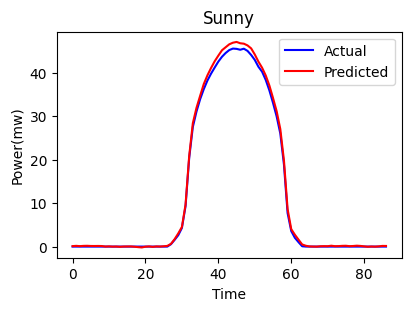

In [15]:
# 创建一个新图表
plt.figure(figsize=(4, 3),constrained_layout=True)

# 绘制 y_test_original（蓝色折线）
plt.plot(y_test_original, label='Actual', color='blue')

# 绘制 y_pred_original（红色折线）
plt.plot(y_pred_original, label='Predicted', color='red')

# 添加图例
plt.legend()

# 设置横轴和纵轴标签
plt.xlabel('Time')
plt.ylabel('Power(mw)')

# 设置图表标题
plt.title('Sunny')
plt.savefig('Sunny.pdf', format='pdf')
# 显示图表
plt.show()

In [ ]:
"""
k=10 a=102 lr=0.042205 batchsize=126
Mean Squared Error (MSE): 1.281830548569668
Root Mean Squared Error (RMSE): 1.1321795566824495
Mean Absolute Error (MAE): 0.6603292524291041
Mean Bias Error(MBE): -0.5918875434321045
NRMSE: 0.023953392328370793
Explained Variance Score (EVS): 0.9951084471098871
R² Score: 0.9932687664538937

k=5,a=2000,lr=0.001,batchsize=32
Mean Squared Error (MSE): 2.5375927630864688
Root Mean Squared Error (RMSE): 1.5929823486424666
Mean Absolute Error (MAE): 0.9505564288293538
Mean Bias Error(MBE): -0.32050408159417654
NRMSE: 0.033702543862399736
Explained Variance Score (EVS): 0.987213849796436
R² Score: 0.986674424671573

k=10,a=102,lr=0.001,batchsize=32
Mean Squared Error (MSE): 2.3585962364776254
Root Mean Squared Error (RMSE): 1.5357721955021928
Mean Absolute Error (MAE): 0.866226516082425
Mean Bias Error(MBE): -0.3680169083598242
NRMSE: 0.032492155249350875
Explained Variance Score (EVS): 0.9883255959342422
R² Score: 0.9876143830973496

k=5,a=2000,lr=0.042205,batchsize=126
Mean Squared Error (MSE): 2.603251365490998
Root Mean Squared Error (RMSE): 1.613459440299321
Mean Absolute Error (MAE): 0.9362612830270756
Mean Bias Error(MBE): -0.36045341901268946
NRMSE: 0.034135775329357076
Explained Variance Score (EVS): 0.9870119133940113
R² Score: 0.9863296338662758
"""
"""
春：
Mean Squared Error (MSE): 0.03907981526257194
Root Mean Squared Error (RMSE): 0.19768615344169135
Mean Absolute Error (MAE): 0.149363844864557
Mean Bias Error(MBE): -0.08706798394735626
NRMSE: 0.004009096550018825
Explained Variance Score (EVS): 0.9998797948630612
R² Score: 0.9998508651921003

夏：
Mean Squared Error (MSE): 0.06470731397481705
Root Mean Squared Error (RMSE): 0.2543763235342807
Mean Absolute Error (MAE): 0.1758910686806507
Mean Bias Error(MBE): -0.05845751311706907
NRMSE: 0.005253914365994903
Explained Variance Score (EVS): 0.9996940172223033
R² Score: 0.9996769568777407

秋：
Mean Squared Error (MSE): 0.1342343345470074
Root Mean Squared Error (RMSE): 0.36638004114171857
Mean Absolute Error (MAE): 0.2700504533126961
Mean Bias Error(MBE): -0.24293451060667137
NRMSE: 0.007637011280040709
Explained Variance Score (EVS): 0.9996712751374798
R² Score: 0.9996769568777407
冬：
Mean Squared Error (MSE): 0.08491246272941218
Root Mean Squared Error (RMSE): 0.29139743089020564
Mean Absolute Error (MAE): 0.2489795231285903
Mean Bias Error(MBE): -0.22723813445504779
NRMSE: 0.005935322519494634
Explained Variance Score (EVS): 0.9998370928166594
R Score: 0.9995842906584602
"""

"""
雨：
Mean Squared Error (MSE): 0.17000471879319645
Root Mean Squared Error (RMSE): 0.4123162848993433
Mean Absolute Error (MAE): 0.322484967272446
Mean Bias Error(MBE): -0.31883784351963285
NRMSE: 0.021724028634929407
Explained Variance Score (EVS): 0.9979601883377442
R² Score: 0.9949262315035651

阴天：
Mean Squared Error (MSE): 0.2608098800936624
Root Mean Squared Error (RMSE): 0.5106954866587939
Mean Absolute Error (MAE): 0.3278896105829642
Mean Bias Error(MBE): -0.29821322716544
NRMSE: 0.013459780837904561
Explained Variance Score (EVS): 0.9984781888136489
R² Score: 0.9976907942943477

晴：
Mean Squared Error (MSE): 0.4832472580579145
Root Mean Squared Error (RMSE): 0.6951598794938575
Mean Absolute Error (MAE): 0.4663275562239322
Mean Bias Error(MBE): -0.45302974181910477
NRMSE: 0.015254612899403
Explained Variance Score (EVS): 0.9991272031189291
R² Score: 0.998482879354899
"""


